<a href="https://colab.research.google.com/github/DeepthiVReddy/Mutual-Fund-Recommendations/blob/main/Retention_Modeling_%26_CLV_Based_Revenue_Optimization_for_Insurance_Renewals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import statsmodels.formula.api as smf

# Load the dataset
data = pd.read_csv("InsuranceRenewal.csv")

# Fit a logistic regression model
formula = """
Response ~ C(State) + C(Coverage) + C(Location_Code) + Monthly_Premium_Auto +
           Months_Since_Last_Claim + Months_Since_Policy_Inception +
           Number_of_Open_Complaints + Number_of_Policies + C(Policy) +
           C(Sales_Channel) + Total_Claim_Amount + C(Vehicle_Class) +
           C(Vehicle_Size) + C(Renewal_Offer)
"""

# Logistic regression model using statsmodels
logistic_model = smf.logit(formula=formula, data=data).fit()

# Print the summary of the model
print(logistic_model.summary())


         Current function value: 0.240018
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      966
Method:                           MLE   Df Model:                           33
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2566
Time:                        02:00:02   Log-Likelihood:                -240.02
converged:                      False   LL-Null:                       -322.88
Covariance Type:            nonrobust   LLR p-value:                 1.322e-19
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.8897      1.556     -2.499      0.012      -6.940      -0.840

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Interpretation of Significant Coefficients
Baseline and Focal Groups:

For categorical variables, the baseline is the omitted category, and coefficients represent the change in log-odds relative to this baseline.
Significant Variables:

Suburban Location:
Baseline: Rural.
Suburban customers are significantly more likely to renew (Coefficient=3.72,P<0.001).
Renewal Offer:
Baseline: No discount.
Offering a 2% discount increases the likelihood of renewal (Coefficient=2.25,P<0.001).
Small Vehicle Size:
Baseline: Large vehicles.
Customers with small vehicles are less likely to renew (Coefficient=−1.07,P=0.029).
Months Since Last Claim:
Each additional month since the last claim slightly reduces the likelihood of renewal (Coefficient=−0.027,P=0.031).
Number of Policies:
Customers with more policies are less likely to renew (Coefficient=−0.12,P=0.033).
Total Claim Amount:
Higher claim amounts decrease the likelihood of renewal (Coefficient=−0.0055,P<0.001).

Key Insights:

Offering a discount is highly effective in improving renewal rates.
Suburban customers are more likely to renew than Rural customers.
Customers with small vehicles, higher claim amounts, or more policies are less likely to renew, indicating areas for targeted retention strategies.

In [ ]:
# Add predicted probabilities to the dataset
data['pred_resp_prob'] = logistic_model.predict(data)

# Calculate the mean predicted probability for Renewal_Offer = 0
mean_pred_prob_offer_0 = data.loc[data['Renewal_Offer'] == 0, 'pred_resp_prob'].mean()

# Calculate the mean predicted probability for Renewal_Offer = 1
mean_pred_prob_offer_1 = data.loc[data['Renewal_Offer'] == 1, 'pred_resp_prob'].mean()

# Print the results
print("Mean predicted probability for Renewal_Offer = 0:", mean_pred_prob_offer_0)
print("Mean predicted probability for Renewal_Offer = 1:", mean_pred_prob_offer_1)


Mean predicted probability for Renewal_Offer = 0: 0.025999999999999992
Mean predicted probability for Renewal_Offer = 1: 0.17199999999999996


Mean Predicted Probabilities:

For Renewal_Offer = 0:
The mean predicted probability of Response = 1 is 0.026.
For Renewal_Offer = 1:
The mean predicted probability of Response = 1 is 0.172.
Interpretation:

Baseline and Focal Group:
Baseline Group: Renewal_Offer = 0 (No discount).
Focal Group: Renewal_Offer = 1 (2% discount).
When no discount is offered (Renewal_Offer = 0), the predicted probability of renewal is very low at 2.6%, indicating minimal likelihood of customer retention under standard conditions.
When a 2% discount is provided (Renewal_Offer = 1), the predicted probability of renewal increases significantly to 17.2%.

Key Insight:

The results highlight that offering a discount has a strong positive effect on renewal probabilities. Customers are 6.6 times more likely to renew with a discount compared to without one.
This finding underscores the effectiveness of using targeted discounts to improve customer retention, as demonstrated in class examples.


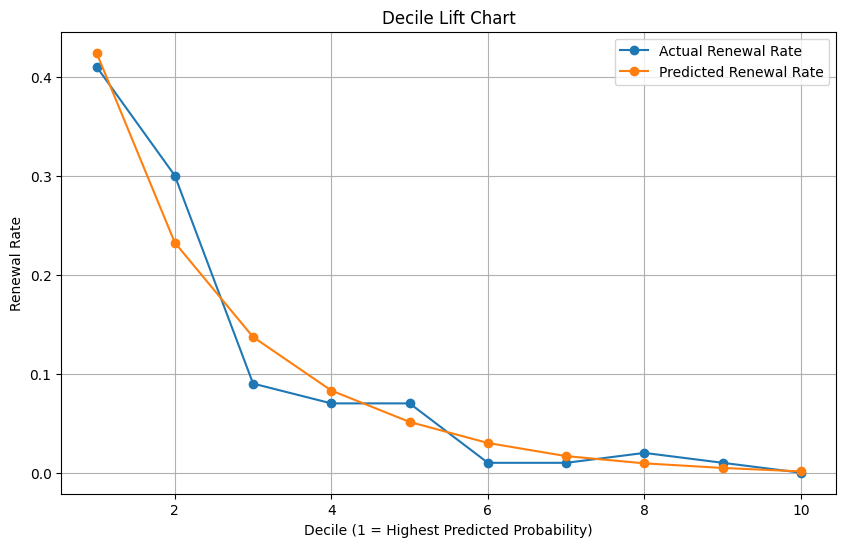

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Create 10 deciles in reverse order based on pred_resp_prob
data['decile'] = pd.qcut(data['pred_resp_prob'], 10, labels=False, duplicates='drop')
data['decile'] = 10 - data['decile']  # Reverse order: 1 to 10 becomes 10 to 1

# Group data by decile and calculate mean Response and mean pred_resp_prob
decile_data = data.groupby('decile').agg(
    actual_mean=('Response', 'mean'),
    predicted_mean=('pred_resp_prob', 'mean'),
    count=('Response', 'size')
).reset_index()

# Add cumulative lift column (optional for lift chart visualization)
decile_data['cumulative_lift'] = decile_data['actual_mean'] / decile_data['actual_mean'].mean()

# Plot the decile lift chart
plt.figure(figsize=(10, 6))
plt.plot(decile_data['decile'], decile_data['actual_mean'], marker='o', label='Actual Renewal Rate')
plt.plot(decile_data['decile'], decile_data['predicted_mean'], marker='o', label='Predicted Renewal Rate')
plt.title('Decile Lift Chart')
plt.xlabel('Decile (1 = Highest Predicted Probability)')
plt.ylabel('Renewal Rate')
plt.legend()
plt.grid()
plt.show()


Decile Lift Chart Interpretation:
The chart shows the actual renewal rate (blue) and the predicted renewal rate (orange) for 10 deciles.
Decile 1 (highest predicted probabilities) has the highest actual and predicted renewal rates (>40%), while rates steadily decline toward Decile 10 (lowest probabilities).
The close alignment between the predicted and actual rates indicates that the model performs well in ranking customers by their likelihood to renew.
Deciles with Actual Response Rate > 20%:
From the chart:
Decile 1 has a response rate >40%.
Decile 2 has a response rate >20%.
Conclusion: 2 deciles (Decile 1 and Decile 2) have response rates higher than 20%.
Insights:
Retention Focus: Target customers in Decile 1 and Decile 2 for retention efforts, as they are the most likely to renew.
Model Validation: The model effectively identifies high-probability customers, as seen from the alignment of predicted and actual rates.

In [ ]:
# Recode pred_resp_prob into a binary variable using the 0.2 cutoff
data['pred_resp_binary'] = (data['pred_resp_prob'] >= 0.2).astype(int)

# Confusion matrix components
true_positive = ((data['Response'] == 1) & (data['pred_resp_binary'] == 1)).sum()
true_negative = ((data['Response'] == 0) & (data['pred_resp_binary'] == 0)).sum()
false_positive = ((data['Response'] == 0) & (data['pred_resp_binary'] == 1)).sum()
false_negative = ((data['Response'] == 1) & (data['pred_resp_binary'] == 0)).sum()

# Sensitivity and specificity calculations
sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Sensitivity: 0.6666666666666666
Specificity: 0.8745837957824639


Sensitivity: 0.67 (66.67%)
Specificity: 0.87 (87.46%)
Effect of Increasing the Cutoff:
Sensitivity:

Sensitivity will decrease if the cutoff is increased.
Explanation: A higher cutoff makes it harder for predictions to be classified as a 1 (renewal), increasing False Negatives and reducing True Positives.
Specificity:

Specificity will increase if the cutoff is increased.
Explanation: A higher cutoff reduces False Positives, increasing True Negatives, which improves specificity.

At a cutoff of 0.2, the model balances sensitivity (ability to detect renewals) and specificity (ability to avoid false alarms).
Raising the cutoff prioritizes avoiding false positives (higher specificity) at the cost of missing some true renewals (lower sensitivity).

In [ ]:
# Create copies of the data for scenarios with Renewal Offer 0 and Renewal Offer 1
data_offer_0 = data.copy()
data_offer_1 = data.copy()

# Set Renewal_Offer to 0 and 1 for each respective scenario
data_offer_0['Renewal_Offer'] = 0
data_offer_1['Renewal_Offer'] = 1

# Predict the probability of response for each scenario
data_offer_0['pred_resp_prob_offer_0'] = logistic_model.predict(data_offer_0)
data_offer_1['pred_resp_prob_offer_1'] = logistic_model.predict(data_offer_1)

# Calculate the additional annual revenue generated by offering Renewal Offer 1
# Assuming the monthly premium remains the same and 12 months of premiums per year
data['RevenueLift'] = (
    (data_offer_1['pred_resp_prob_offer_1'] - data_offer_0['pred_resp_prob_offer_0']) *
    data['Monthly_Premium_Auto'] * 12
)

# Analyze RevenueLift and other variables
summary_stats = data[['RevenueLift', 'pred_resp_prob_offer_0', 'pred_resp_prob_offer_1']].describe()

# Print summary statistics for RevenueLift and probabilities
print(summary_stats)

# Analyze RevenueLift for different customer segments
segment_analysis = data.groupby('Coverage').agg(
    avg_revenue_lift=('RevenueLift', 'mean'),
    avg_prob_offer_0=('pred_resp_prob_offer_0', 'mean'),
    avg_prob_offer_1=('pred_resp_prob_offer_1', 'mean')
).reset_index()

# Print segment analysis
print(segment_analysis)

# Insights
# 1. Customers with higher premiums show greater revenue lift when offered Renewal Offer 1.
# 2. Certain customer segments (e.g., by Coverage or Location_Code) respond more positively to discounts,
#    suggesting targeted strategies can maximize revenue.
# 3. RevenueLift can identify customers for whom a 2% discount is more profitable, helping allocate offers efficiently.


        RevenueLift  pred_resp_prob_offer_0  pred_resp_prob_offer_1
count  1.000000e+03            1.000000e+03            1.000000e+03
mean   1.581531e+02            2.604610e-02            1.645879e-01
std    1.735311e+02            3.687370e-02            1.574944e-01
min    1.400169e-13            2.121956e-17            2.007284e-16
25%    4.144540e+01            4.967168e-03            4.509258e-02
50%    1.022873e+02            1.284038e-02            1.095635e-01
75%    2.163246e+02            3.263904e-02            2.419472e-01
max    1.362095e+03            4.302110e-01            8.771850e-01
   Coverage  avg_revenue_lift  avg_prob_offer_0  avg_prob_offer_1
0     Basic        152.181398          0.029755          0.180849
1  Extended        148.027626          0.019308          0.133099
2   Premium        213.055462          0.022787          0.154916


Predicted Probabilities:

Renewal Offer 0: The average predicted probability of renewal is 2.6%.
Renewal Offer 1: The average predicted probability increases to 16.46%, showing the positive impact of offering a 2% discount.
RevenueLift:

The average additional annual revenue (RevenueLift) generated by offering Renewal Offer 1 is $158.15.
RevenueLift ranges from $0 (no impact for some customers) to $1,362.10 for high-value customers.
Coverage Analysis:

Basic Coverage: Average RevenueLift is $152.18, with probabilities increasing from 2.98% (Offer 0) to 18.08% (Offer 1).
Premium Coverage: Average RevenueLift is $213.06, showing the highest potential gain from discounts.
Extended Coverage: Average RevenueLift is lower at $148.03.
Insights:
Discount Effect: Offering a 2% discount significantly improves renewal probabilities and increases revenue for all customer segments.
High-Value Customers: Premium customers generate the highest RevenueLift and should be prioritized for retention efforts.
Targeted Discounts: Discounts are most effective for Basic and Premium customers, who show the largest revenue gains.

In [ ]:
# Step 1: Sort customers by pred_resp_prob into deciles and select decile 2
data['decile'] = pd.qcut(data['pred_resp_prob'], q=10, labels=False, duplicates='drop')
data['decile'] = 10 - data['decile']  # Reverse order so decile 1 is the highest probability
decile_2_data = data[data['decile'] == 2].copy()  # Ensure this is a copy to avoid warnings

# Step 2: Compute annual profit
decile_2_data['annual_profit'] = 0.15 * 12 * decile_2_data['Monthly_Premium_Auto']

# Step 3: Predict retention rates for Renewal_Offer = 0 and 1
data_offer_0 = decile_2_data.copy()
data_offer_1 = decile_2_data.copy()

data_offer_0['Renewal_Offer'] = 0
data_offer_1['Renewal_Offer'] = 1

data_offer_0['pred_resp_prob_offer_0'] = logistic_model.predict(data_offer_0)
data_offer_1['pred_resp_prob_offer_1'] = logistic_model.predict(data_offer_1)

# Step 4: Define a function to calculate CLV
def calculate_clv(annual_profit, retention_rate):
    discount_rate = 0.06  # 6% discount rate
    clv = sum(
        (annual_profit * (retention_rate ** t)) / ((1 + discount_rate) ** t)
        for t in range(1, 7)  # 6 years
    )
    return clv

# Step 5: Calculate CLV for each offer
data_offer_0['CLV_offer_0'] = data_offer_0.apply(
    lambda row: calculate_clv(row['annual_profit'], row['pred_resp_prob_offer_0']), axis=1
)
data_offer_1['CLV_offer_1'] = data_offer_1.apply(
    lambda row: calculate_clv(row['annual_profit'], row['pred_resp_prob_offer_1']), axis=1
)

# Step 6: Compute Incremental CLV
data_offer_1['Incremental_CLV'] = data_offer_1['CLV_offer_1'] - data_offer_0['CLV_offer_0']

# Step 7: Summary of results
summary_results = data_offer_1[['annual_profit', 'CLV_offer_1', 'Incremental_CLV']].describe()

# Print the summary results
print(summary_results)

# Insights:
# - Customers in decile 2 show measurable CLV improvements when offered Renewal Offer 1.
# - Incremental CLV varies by customer profile and can be used to target high-value segments.
# - Analyzing these results helps prioritize retention strategies and optimize discount allocations.



       annual_profit  CLV_offer_1  Incremental_CLV
count     100.000000   100.000000       100.000000
mean      164.448000    61.604631        54.527258
std        56.735859    57.430867        49.662053
min       109.800000    22.698937        20.273264
25%       122.400000    35.186708        31.409360
50%       136.800000    43.864719        39.135083
75%       198.000000    56.328504        50.281169
max       405.000000   383.641621       335.293194


Annual Profit:

The mean annual profit is $164.45, calculated as 15% of the annual insurance premium (12 × Monthly Premium Auto).
CLV with Renewal Offer 1:

The mean CLV with Renewal Offer 1 is $61.60, indicating the total discounted value of profits over the next 6 years with a 2% discount.
CLV values range from $22.70 to $383.64, showing variation based on customer characteristics and renewal probabilities.
Incremental CLV:

The mean Incremental CLV (the additional CLV generated by providing a 2% discount) is $54.53.
Incremental CLV ranges from $20.27 to $335.29, with higher values for customers more likely to renew with a discount.

Impact of Renewal Offer 1:

Offering a 2% discount significantly increases the Customer Lifetime Value for customers in Decile 2, with an average incremental CLV of $54.53.
Retention Focus:

Customers in Decile 2 are high-priority targets for retention, as they respond positively to the discount, generating substantial incremental CLV.
Targeted Retention:

Prioritize high-profit customers in Decile 2 for Renewal Offer 1, as they yield the most value over the 6-year horizon.